In [1]:
#This project has been done on Google colab
#data mounted from google drive. You can change path to local files to run it locally
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm
from fbprophet import Prophet
import math 
from sklearn.linear_model import Lasso
from sklearn import svm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Load all data into dataframes
#Please change filepath to your own file path while running
filepath = "/content/drive/My Drive/"
energydf=pd.read_csv(filepath + "energy-and-weather-data/energy_dataset.csv")
weatherdf=pd.read_csv(filepath + "energy-and-weather-data/weather_features.csv")

In [0]:
#Preprocessing and cleaning
#remove columns with all zero and NaN
energydf=energydf.replace(0.0,np.nan)
energydf.dropna(axis=1,how='all',inplace=True)
#remove forecast columns
energydf = energydf.drop(['total load forecast', 'forecast solar day ahead','forecast wind onshore day ahead'], axis=1)
#convert time to datetime object
energydf['time'] = pd.to_datetime(energydf['time'], utc=True, infer_datetime_format=True)
#Fill NA values with last value
energydf.fillna(method='ffill',inplace=True)
energydf.fillna(method='ffill',inplace=True)
#set index as date
#energydf=energydf.set_index('time')

In [5]:
#pd.set_option('max_rows', 100)
energydf.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


In [0]:
def MakePlot(prediction,actual,pttitle=None):
    fig, ax = plt.subplots(figsize=(20,5))
    predictiondf = pd.DataFrame(data=prediction, columns=["Prediction"])
    predictiondf = predictiondf.groupby(predictiondf.index // 24).median()
    actualdf = pd.DataFrame(data=actual, columns=["Prediction"])
    actualdf = actualdf.groupby(actualdf.index // 24).median()
    #df.plot(y=param,use_index=True,ax=axes[i,j]) 
    predictiondf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color='red',title=pttitle,label='Predicted Price')
    actualdf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color='darkcyan',label = 'Actual Price' )
    ax.set_xlabel("Test sample")
    ax.set_ylabel("Energy Price")
    plt.legend()


Text(0, 0.5, 'Energy Price')

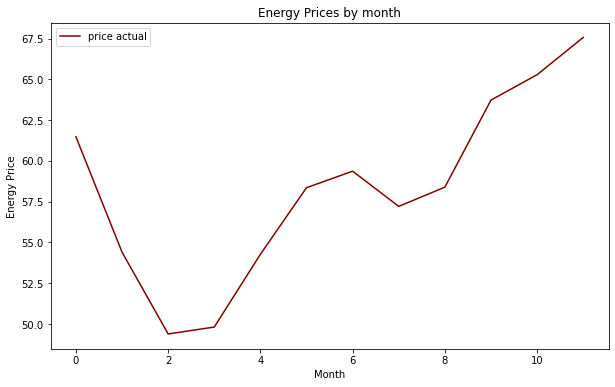

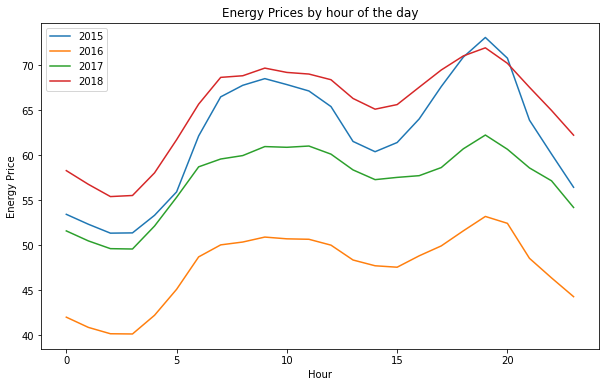

In [7]:
#sns.set_style("ticks")
#sns.set_style("dark")
#sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

plotdf = energydf.groupby(energydf["time"].dt.month)['price actual'].median().reset_index() #We take median and not mean because of the outliers
ax2 = plotdf.plot(y='price actual',title='Energy Prices by month',x_compat=True,figsize=(10,6),c='Maroon')
ax2.set_xlabel("Month")
ax2.set_ylabel("Energy Price")

energydaily = energydf.copy()
energy2015=energydaily[energydaily.time.dt.year == 2015]
energy2016=energydaily[energydaily.time.dt.year == 2016]
energy2017=energydaily[energydaily.time.dt.year == 2017]
energy2018=energydaily[energydaily.time.dt.year == 2018]
plotdf15 = energy2015.groupby(energy2015["time"].dt.hour)['price actual'].median().reset_index() #We take median and not mean because of the outliers
plotdf16 = energy2016.groupby(energy2016["time"].dt.hour)['price actual'].median().reset_index() #We take median and not mean because of the outliers
plotdf17 = energy2017.groupby(energy2017["time"].dt.hour)['price actual'].median().reset_index() #We take median and not mean because of the outliers
plotdf18 = energy2018.groupby(energy2018["time"].dt.hour)['price actual'].median().reset_index() #We take median and not mean because of the outliers
ax = plotdf15.plot(y='price actual',title='Energy Prices by hour of the day',x_compat=True,figsize=(10,6),label='2015')
plotdf16.plot(y='price actual',x_compat=True,ax=ax,label='2016')
plotdf17.plot(y='price actual',x_compat=True,ax=ax,label='2017')
plotdf18.plot(y='price actual',x_compat=True,ax=ax,label='2018')
ax.set_xlabel("Hour")
ax.set_ylabel("Energy Price")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0, 0.5, 'Log Energy Price')

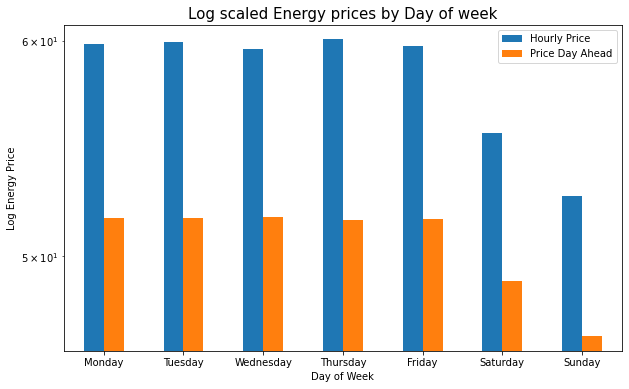

In [8]:
plotdf = energydf.copy()
plotdf['day_of_week'] = plotdf['time'].dt.day_name()
dayorder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=dayorder, ordered=True)
plotdf['day_of_week'] = plotdf['day_of_week'].astype(cat_type)
plotdf = plotdf.groupby(plotdf['day_of_week'])['price actual','price day ahead'].median().reset_index() #We take median and not mean because of the outliers
#plotdf['price actual'] -= plotdf['price actual'].min()
#plotdf['price actual'] /= plotdf['price actual'].max()
ax = plotdf.plot.bar(x='day_of_week', y=['price actual','price day ahead'],logy=True,rot=0,figsize=(10,6),label=['Hourly Price','Price Day Ahead'])
ax.set_title("Log scaled Energy prices by Day of week", fontsize=15)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Log Energy Price")
#plotdf.plot(y='price actual',title='Price by month')

In [0]:
energydf["Month"] =energydf["time"].dt.month
energydf["Hour"] =energydf["time"].dt.hour
#energydf['day_of_week'] = energydf['time'].dt.day_name()
energydf['isWeekend'] = np.where((energydf['time'].dt.dayofweek) < 5,1,0)

In [10]:
weatherdf['time'] = pd.to_datetime(weatherdf['dt_iso'], utc=True, infer_datetime_format=True)
weatherdf = weatherdf.drop(['dt_iso'], axis=1)
weatherdf=weatherdf.replace(0.0,np.nan)
weatherdf.fillna(method='ffill',inplace=True)
weatherdf.dropna(axis=1,how='all',inplace=True)
# Categorical boolean mask
categorical_feature_mask = weatherdf.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = weatherdf.columns[categorical_feature_mask].tolist()
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
weatherdf[categorical_cols] = weatherdf[categorical_cols].apply(lambda col: le.fit_transform(col))
weatherdf = weatherdf.reset_index().drop_duplicates(subset=['time', 'city_name'],keep='first').set_index('time')
weatherdf= weatherdf.groupby('time').median().reset_index()
weatherdf = weatherdf.drop(['index','city_name'], axis=1)
weatherdf.head()

,time,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,270.475,270.475,270.475,1035,77,1,62,0.3,0.0225,0.129,0,800,0,33,2
1,2015-01-01 00:00:00+00:00,270.475,270.475,270.475,1035,77,1,62,0.3,0.0225,0.129,0,800,0,33,2
2,2015-01-01 01:00:00+00:00,269.686,269.686,269.686,1036,78,1,48,0.3,0.0225,0.129,0,800,0,33,2
3,2015-01-01 02:00:00+00:00,269.686,269.686,269.686,1035,78,1,48,0.3,0.0225,0.129,0,800,0,33,2
4,2015-01-01 03:00:00+00:00,269.686,269.686,269.686,1035,78,1,48,0.3,0.0225,0.129,0,800,0,33,2


In [11]:
energydf= pd.merge(energydf, weatherdf, on="time")
energydf.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,Month,Hour,isWeekend,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,12,23,1,270.475,270.475,270.475,1035,77,1,62,0.3,0.0225,0.129,0,800,0,33,2
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,1,0,1,270.475,270.475,270.475,1035,77,1,62,0.3,0.0225,0.129,0,800,0,33,2
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,1,1,1,269.686,269.686,269.686,1036,78,1,48,0.3,0.0225,0.129,0,800,0,33,2
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,1,2,1,269.686,269.686,269.686,1035,78,1,48,0.3,0.0225,0.129,0,800,0,33,2
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,1,3,1,269.686,269.686,269.686,1035,78,1,48,0.3,0.0225,0.129,0,800,0,33,2


In [12]:
#Correlation matrix between columns to see strongly correlated columns
correlations = energydf.corr(method='pearson')
print(correlations['price actual'].to_string())

generation biomass                             0.143156
generation fossil brown coal/lignite           0.272125
generation fossil gas                          0.461548
generation fossil hard coal                    0.465957
generation fossil oil                          0.285867
generation hydro pumped storage consumption   -0.418546
generation hydro run-of-river and poundage    -0.136556
generation hydro water reservoir               0.071901
generation nuclear                            -0.052625
generation other                               0.099981
generation other renewable                     0.256443
generation solar                               0.098579
generation waste                               0.169335
generation wind onshore                       -0.220300
total load actual                              0.435573
price day ahead                                0.732155
price actual                                   1.000000
Month                                          0

Text(0, 0.5, 'Energy prices')

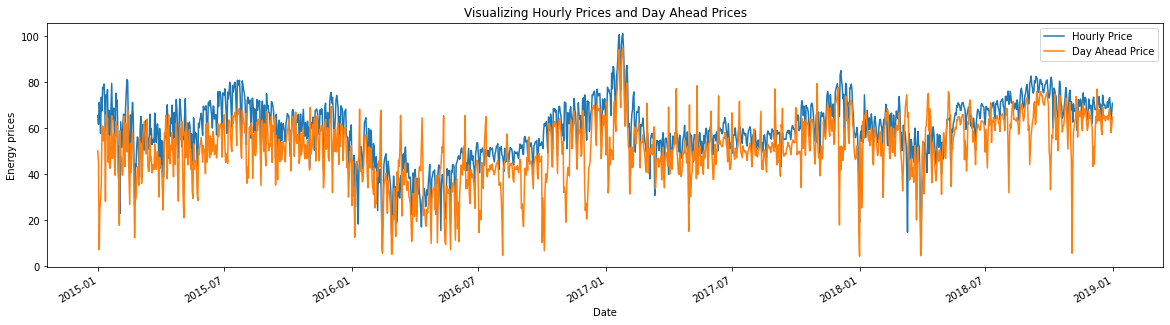

In [13]:
energydaily = energydf.copy()
energydaily["time"]= energydaily["time"].dt.floor(freq = 'D')
energydaily= energydaily.groupby("time").median().reset_index()
ax = energydaily.plot(y='price actual',x='time',figsize=(20,5),x_compat=True,label='Hourly Price',title='Visualizing Hourly Prices and Day Ahead Prices')
energydaily.plot(y='price day ahead',x='time',ax=ax,x_compat=True, label='Day Ahead Price')
ax.set_xlabel("Date")
ax.set_ylabel("Energy prices")

'\n    predictiondf = pd.DataFrame(data=prediction, columns=["Prediction"])\n    predictiondf = predictiondf.groupby(predictiondf.index // 24).median()\n    actualdf = pd.DataFrame(data=actual, columns=["Prediction"])\n    actualdf = actualdf.groupby(actualdf.index // 24).median()\n    #df.plot(y=param,use_index=True,ax=axes[i,j]) \n    predictiondf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color=\'red\' )\n    actualdf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color=\'blue\' )\n    '

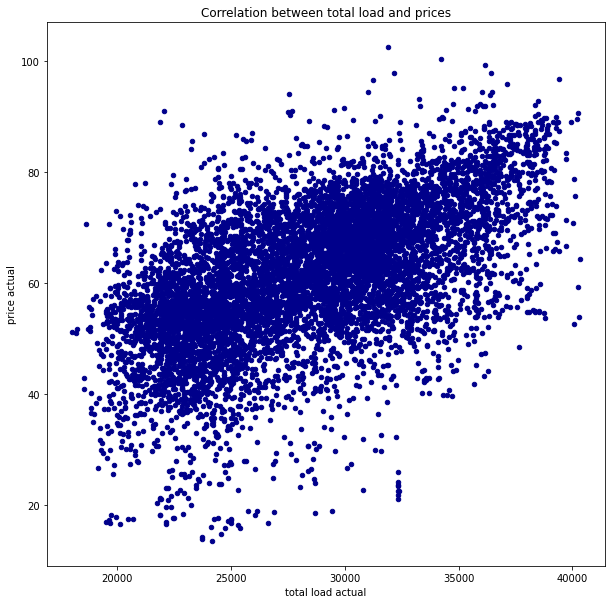

In [14]:
#fig, ax = plt.subplots(figsize=(23,5))
#energydaily.plot(y='price actual',x='time',logy=True,ax=ax,color='red')
#energydaily.plot(y='total load actual',x='time',logy=True,ax=ax, ls="-",color='blue')
#plt.legend()
energydaily = energydf.copy()
energydaily=energydaily[energydaily.time.dt.year == 2015]
#energydaily=energydaily[energydaily.time.dt.month == 1]
ax1 = energydaily.plot.scatter(x='total load actual',
                      y='price actual',
                      c='DarkBlue',figsize=(10,10),title='Correlation between total load and prices')
"""
    predictiondf = pd.DataFrame(data=prediction, columns=["Prediction"])
    predictiondf = predictiondf.groupby(predictiondf.index // 24).median()
    actualdf = pd.DataFrame(data=actual, columns=["Prediction"])
    actualdf = actualdf.groupby(actualdf.index // 24).median()
    #df.plot(y=param,use_index=True,ax=axes[i,j]) 
    predictiondf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color='red' )
    actualdf.plot(y="Prediction",use_index=True, ax=ax, ls="-",color='blue' )
    """

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
#ARIMA
#models.append("ARIMA")

def GetBestModel(train):
  optimalp =0
  optimald = 0
  leasterror = float("inf")
  lensplit = int(len(train)*0.8)
  traindata = train[:lensplit]
  validationdata = train[lensplit:]
  for p in range(0,10):
    for d in range(0,2):
      newmodel = ARIMA(traindata, order=(p,d,0))
      model_fit = newmodel.fit(disp=0)
      ypredicted = model_fit.predict(start=lensplit+1, end=len(train)-1)
      error = mean_absolute_percentage_error(validationdata, ypredicted)
      if(error<leasterror):
        leasterror=error
        optimalp = p
        optimald = d
  return optimalp,optimald

def predict_Arima(usagearr):
  #usagearr_scaled = preprocessing.scale(usagearr)
  lendfsplit = int(len(usagearr)*0.8)
  train = usagearr[:lendfsplit]
  test = usagearr[lendfsplit:]
  optimalp,optimald = GetBestModel(train)
  #print(model)
  model = ARIMA(train, order=(optimalp,optimald,0))
  model_fit = model.fit(disp=0)
  #model_fit.plot_diagnostics(figsize=(18, 8))
  #plt.show()
  y_predicted = model_fit.predict(start=lendfsplit+1, end=len(usagearr)-1)
  error = mean_absolute_percentage_error(test, y_predicted)
  #MakePlot(y_predicted,test,"Predicted vs Actual Energy output")
  return error

print("ARIMA:")
pricearr = energydf[['price actual']].values
error = predict_Arima(pricearr)
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

pricearr = energydf[['price day ahead']].values
error = predict_Arima(pricearr)
#hbhourlymae.append(error)
print("Mean absolute error for next day prediction:",error)

ARIMA:
Mean absolute error for hourly prediction: 20.637245266793087
Mean absolute error for next day prediction: 35.0781694934974


Random Forest:
Validation MAE:  1.8699752916123829
Mean absolute error for hourly prediction: 3.7153849405314148
Validation MAE:  1.9113316189719092
Mean absolute error for next day prediction: 5.306557984581748


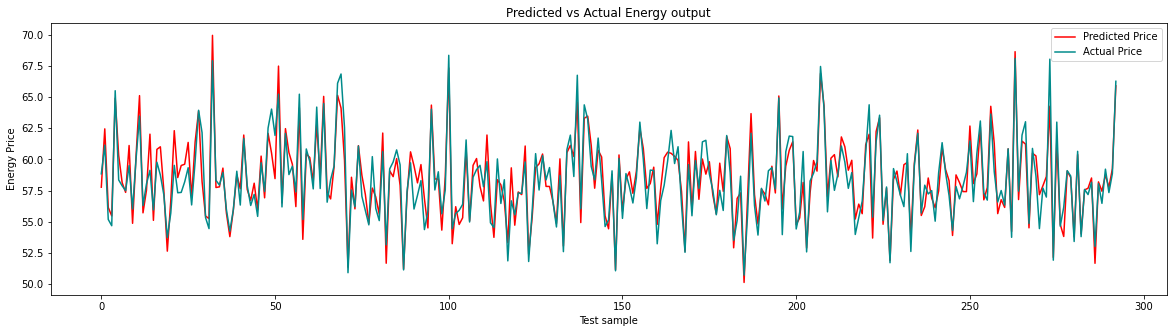

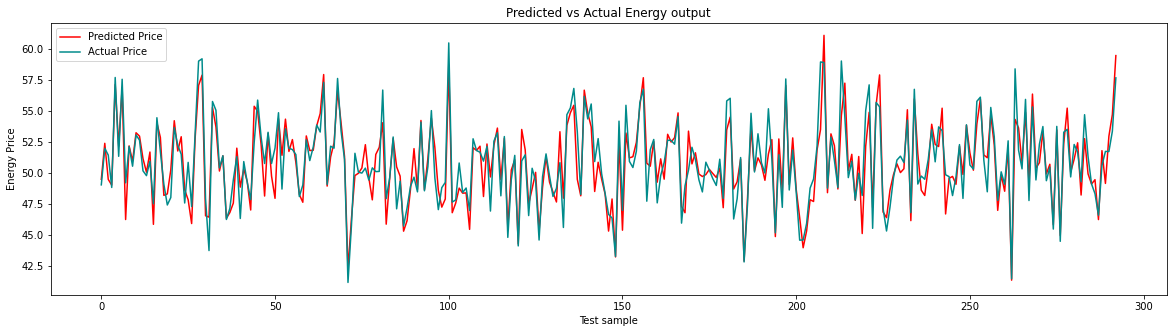

In [17]:
def randomforest(inputdata,frequency):
    inputdf = inputdata.copy()
    scaler = preprocessing.StandardScaler()
    #inputdf[['Usage [kW]', 'temperature']] = scaler.fit_transform(inputdf[['Usage [kW]', 'temperature']])
    if(frequency=="hourly"): 
      inputdf.drop('price day ahead', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price actual'].shift(-1)
    elif(frequency=="daily"):
      inputdf.drop('price actual', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price day ahead'].shift(-1)      
    predictiondf = inputdf["predicted"]
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('time', 1)
    #inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    x = np.array(inputdf)
    y = np.array(predictiondf)
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size= 0.2, random_state=0)
    regr = RandomForestRegressor(max_depth=8, random_state=0)  
    model = regr.fit(xtrain, ytrain)
    lenvalidationsplit = int(len(xtrain)*0.8)
    validationx = xtrain[:lenvalidationsplit-1]
    validationy = ytrain[:lenvalidationsplit-1]
    validationpred = regr.predict(validationx)
    validationerror= mean_absolute_error(validationy, validationpred)
    print("Validation MAE: ",validationerror)
    y_predicted = regr.predict(xtest)
    # Save 2D numpy array to csv file
    #np.savetxt('b_pred_rf.csv', y_predicted, delimiter=',', fmt='%d')
    #error =  mean_absolute_error(ytest, y_predicted)
    error = mean_absolute_percentage_error(ytest, y_predicted)
    #print("MAPE:",mape)
    MakePlot(y_predicted,ytest,"Predicted vs Actual Energy output")
    return error

print("Random Forest:")
error = randomforest(energydf,"hourly")
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

error = randomforest(energydf,"daily")
#hbhourlymae.append(error)
print("Mean absolute error for next day prediction:",error)

Linear Regression:
Validation MAE:  4.631993445968801
Mean absolute error for hourly prediction: 4.598369898217635
Validation MAE:  6.109399941921764
Mean absolute error for next day prediction: 6.29971325954605


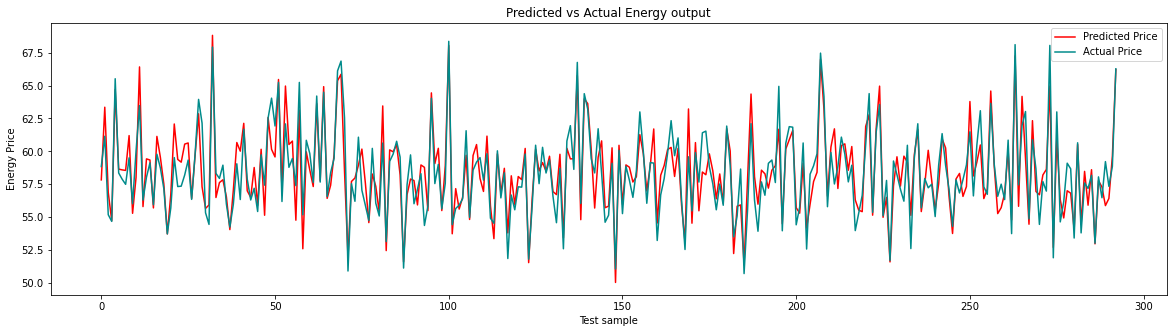

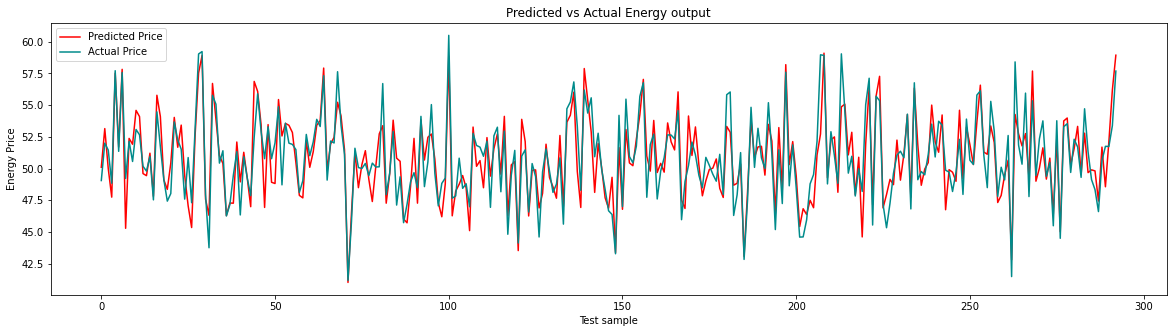

In [18]:
#Linear Regression
#models.append("Linear Regression")

def linearregression(inputdata,frequency):
    inputdf = inputdata.copy()
    #scaler = preprocessing.StandardScaler()
    if(frequency=="hourly"): 
      inputdf.drop('price day ahead', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price actual'].shift(-1)
    elif(frequency=="daily"):
      inputdf.drop('price actual', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price day ahead'].shift(-1)    
    predictiondf = inputdf["predicted"]
    #print(predictiondf.head())
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('time', 1)
    #inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    x = np.array(inputdf)
    y = np.array(predictiondf)
    trainx, testx, trainy, testy = train_test_split(x,y,test_size= 0.2, random_state=0)
    lenvalidationsplit = int(len(trainx)*0.8)
    lr = LinearRegression()
    lr.fit(trainx, trainy)
    validationx = trainx[:lenvalidationsplit-1]
    validationy = trainy[:lenvalidationsplit-1]
    validationpred = lr.predict(validationx)
    validationerror= mean_absolute_percentage_error(validationy, validationpred)
    print("Validation MAE: ",validationerror)
    predicted_y = lr.predict(testx)
    error= mean_absolute_percentage_error(testy, predicted_y)
    MakePlot(predicted_y,testy,"Predicted vs Actual Energy output")
    return error

print("Linear Regression:")
error = linearregression(energydf,"hourly")
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

error = linearregression(energydf,"daily")
#hbhourlymae.append(error)
print("Mean absolute error for next day prediction:",error)

XGBoost:
[09:10:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error for hourly prediction: 3.4633417041079277
[09:10:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error for daily prediction: 5.029392928073709


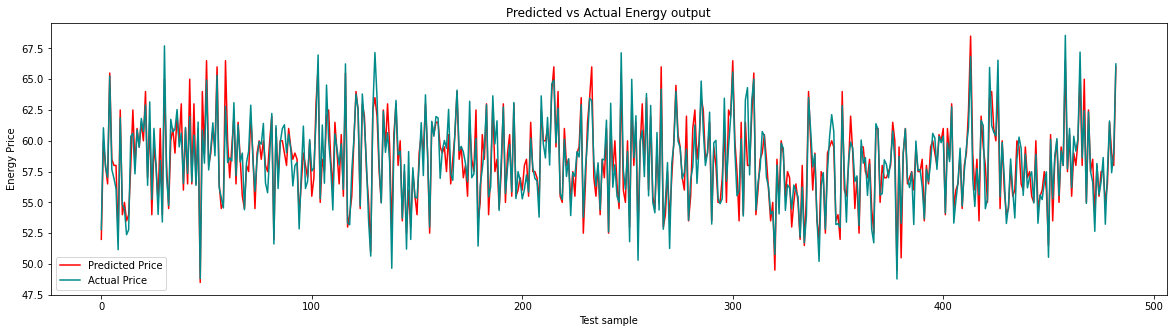

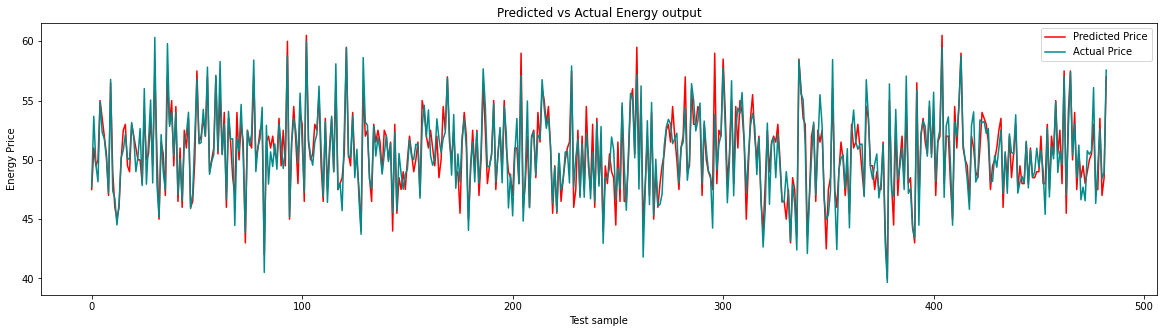

In [19]:
# First XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def XGBoost(inputdata,frequency):
    inputdf = inputdata.copy()
    #scaler = preprocessing.StandardScaler()
    if(frequency=="hourly"): 
      inputdf.drop('price day ahead', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price actual'].shift(-1)
    elif(frequency=="daily"):
      inputdf.drop('price actual', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price day ahead'].shift(-1)    
    predictiondf = inputdf["predicted"]
    #print(predictiondf.head())
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('time', 1)
    #inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    X = np.array(inputdf)
    Y = np.array(predictiondf)
    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    # fit model no training data
    model = XGBRegressor()
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    error = mean_absolute_percentage_error(y_test, predictions)
    MakePlot(predictions,y_test,"Predicted vs Actual Energy output")
    return error

print("XGBoost:")
error = XGBoost(energydf,"hourly")
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

error = XGBoost(energydf,"daily")
#hbhourlymae.append(error)
print("Mean absolute error for daily prediction:",error)

Lasso:
Mean absolute error for hourly prediction: 4.569423391029181
Mean absolute error for daily prediction: 6.079333902132973


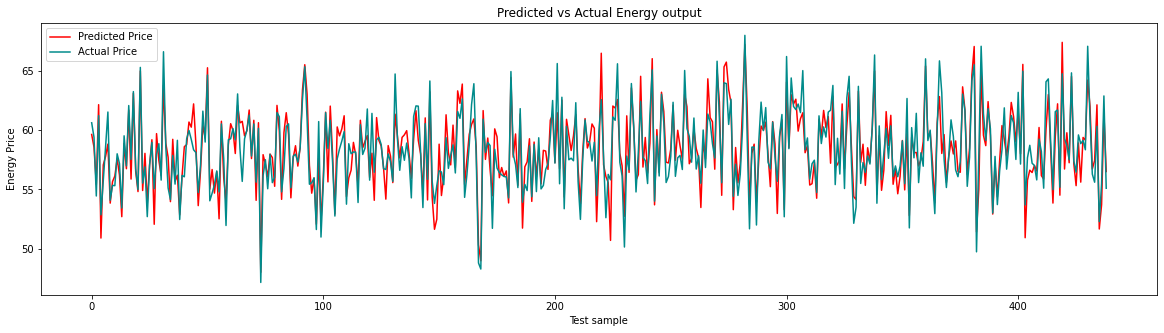

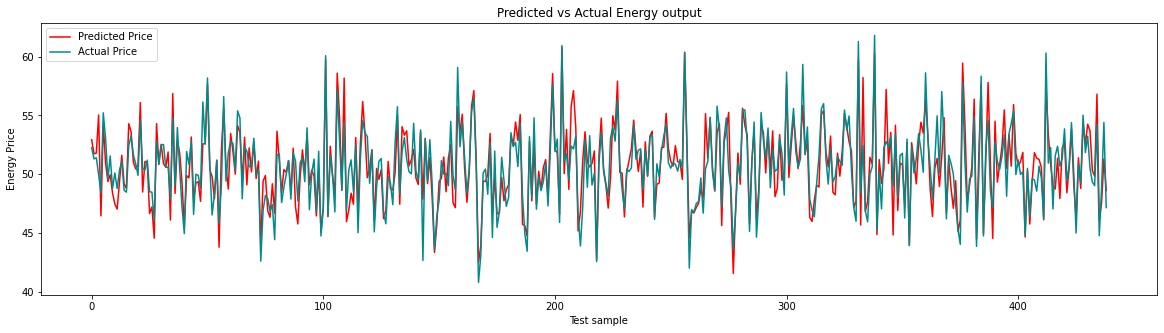

In [20]:
def LassoReg(inputdata,frequency):
    inputdf = inputdata.copy()
    scaler = preprocessing.StandardScaler()
    #inputdf[['Usage [kW]', 'temperature']] = scaler.fit_transform(inputdf[['Usage [kW]', 'temperature']])
    if(frequency=="hourly"): 
      inputdf.drop('price day ahead', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price actual'].shift(-1)
    elif(frequency=="daily"):
      inputdf.drop('price actual', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price day ahead'].shift(-1)      
    predictiondf = inputdf["predicted"]
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('time', 1)
    #inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    X = np.array(inputdf)
    Y = np.array(predictiondf)
    X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
    lasso = Lasso(alpha=0.01, max_iter=10e5)
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_test)
    train_score=lasso.score(X_train,y_train)
    #test_score=lasso.score(X_test,y_test)
    test_score = mean_absolute_percentage_error(y_test,y_pred)
    coeff_used = np.sum(lasso.coef_!=0)
    #print("training score:", train_score) 
    MakePlot(y_pred,y_test,"Predicted vs Actual Energy output")
    return test_score

print("Lasso:")
error = LassoReg(energydf,"hourly")
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

error = LassoReg(energydf,"daily")
#hbhourlymae.append(error)
print("Mean absolute error for daily prediction:",error)



SVM:
Mean absolute error for hourly prediction: 18.901011007921394
Mean absolute error for daily prediction: 19.914672877936717


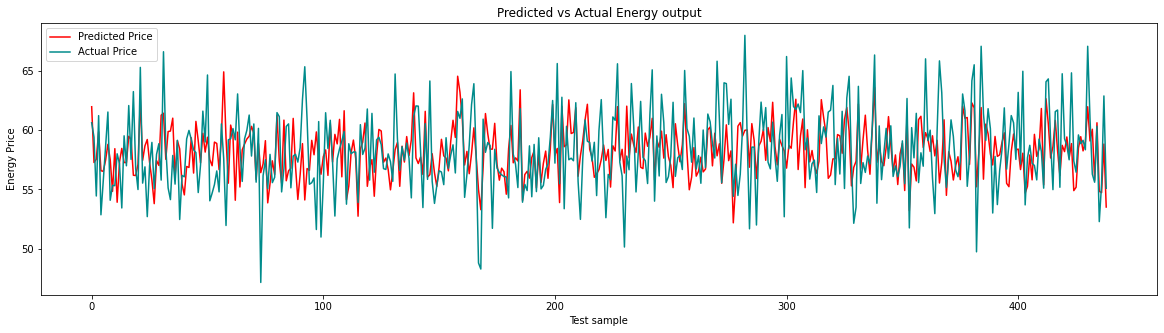

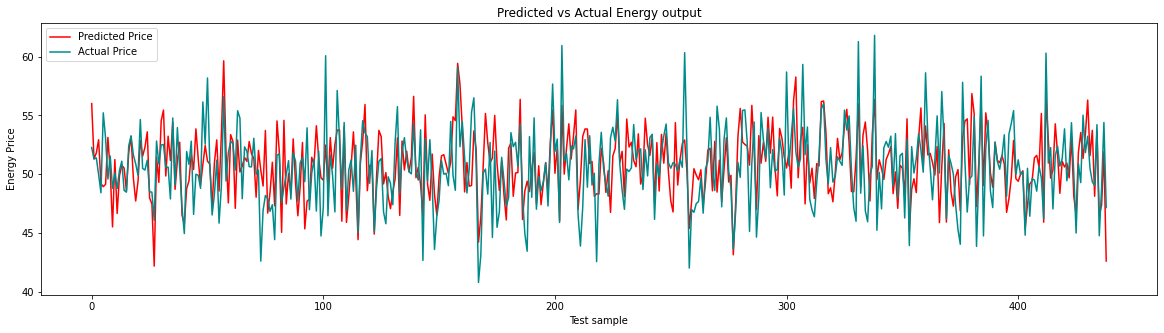

In [21]:
def SVM(inputdata,frequency):
    inputdf = inputdata.copy()
    #scaler = preprocessing.StandardScaler()
    #inputdf[['Usage [kW]', 'temperature']] = scaler.fit_transform(inputdf[['Usage [kW]', 'temperature']])
    if(frequency=="hourly"): 
      inputdf.drop('price day ahead', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price actual'].shift(-1)
    elif(frequency=="daily"):
      inputdf.drop('price actual', axis=1, inplace=True)
      inputdf["predicted"] = inputdf['price day ahead'].shift(-1)      
    predictiondf = inputdf["predicted"]
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('time', 1)
    #inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    X = np.array(inputdf)
    Y = np.array(predictiondf)
    X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
    clf = svm.SVR()
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    train_score=clf.score(X_train,y_train)
    #test_score=lasso.score(X_test,y_test)
    test_score = mean_absolute_percentage_error(y_test,y_pred)
    #print("training score:", train_score) 
    MakePlot(y_pred,y_test,"Predicted vs Actual Energy output")
    return test_score

print("SVM:")
error = SVM(energydf,"hourly")
#hbhourlymae.append(error)
print("Mean absolute error for hourly prediction:",error)

error = SVM(energydf,"daily")
#hbhourlymae.append(error)
print("Mean absolute error for daily prediction:",error)

